0. Colab setup

In [1]:
!pip -q install -U tensorflow matplotlib numpy pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 89.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 75.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 77.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.2 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.2 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; 

1. Imports & reproducibility

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)


plt.rcParams['figure.figsize'] = (8,5)

2. Load MNIST dataset

In [3]:
# Keras builtin MNIST: 60k train, 10k test (grayscale 28x28)
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
x_train shape: (60000, 28, 28)
y_train shape: (60000,)


3. Preprocessing

In [4]:
# Normalize to [0,1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0


# Add channel dimension for CNNs or flatten for dense networks
# We'll implement a simple Dense network (MLP) and also provide CNN option.


# For Dense (flattened)
X_train_flat = x_train.reshape((-1, 28*28))
X_test_flat = x_test.reshape((-1, 28*28))


# For CNN (channels)
X_train_cnn = x_train.reshape((-1, 28, 28, 1))
X_test_cnn = x_test.reshape((-1, 28, 28, 1))


# Convert labels to categorical (one-hot) for training with categorical_crossentropy
num_classes = 10
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

4. Build models

    4.1 Dense (MLP) Model — simple and fast

In [5]:
def build_mlp(input_shape=(28*28,), num_classes=10, dropout_rate=0.3):
  inputs = keras.Input(shape=input_shape)
  x = layers.Dense(512, activation='relu')(inputs)
  x = layers.Dropout(dropout_rate)(x)
  x = layers.Dense(256, activation='relu')(x)
  x = layers.Dropout(dropout_rate)(x)
  outputs = layers.Dense(num_classes, activation='softmax')(x)
  model = keras.Model(inputs, outputs, name='mnist_mlp')
  return model


mlp_model = build_mlp()
mlp_model.summary()

Model: "mnist_mlp"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 535,818 (2.04 MB)

 Trainable params: 535,818 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

4.2 Convolutional Neural Network

In [6]:
def build_cnn(input_shape=(28,28,1), num_classes=10, dropout_rate=0.25):
  inputs = keras.Input(shape=input_shape)
  x = layers.Conv2D(32, kernel_size=(3,3), activation='relu')(inputs)
  x = layers.Conv2D(64, kernel_size=(3,3), activation='relu')(x)
  x = layers.MaxPooling2D(pool_size=(2,2))(x)
  x = layers.Dropout(dropout_rate)(x)
  x = layers.Flatten()(x)
  x = layers.Dense(128, activation='relu')(x)
  x = layers.Dropout(dropout_rate)(x)
  outputs = layers.Dense(num_classes, activation='softmax')(x)
  model = keras.Model(inputs, outputs, name='mnist_cnn')
  return model


cnn_model = build_cnn()
cnn_model.summary()

Model: "mnist_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,199,882 (4.58 MB)

 Trainable params: 1,199,882 (4.58 MB)

 Non-trainable params: 0 (0.00 B)

5. Compile the model

In [7]:
# Choose model: mlp_model or cnn_model
model = cnn_model # change to mlp_model if you prefer the dense network


model.compile(
optimizer='adam',
loss='categorical_crossentropy',
metrics=['accuracy']
)

6. Callbacks (EarlyStopping and ModelCheckpoint)

In [8]:
callbacks = [
keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
keras.callbacks.ModelCheckpoint('best_mnist_model.h5', save_best_only=True)
]

7. Train the model

In [9]:
history = model.fit(
X_train_cnn if model.name=='mnist_cnn' else X_train_flat,
y_train_cat,
epochs=30,
batch_size=128,
validation_split=0.1,
callbacks=callbacks
)

Epoch 1/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.8732 - loss: 0.4175

422/422 ━━━━━━━━━━━━━━━━━━━━ 135s 311ms/step - accuracy: 0.8733 - loss: 0.4169 - val_accuracy: 0.9863 - val_loss: 0.0506
Epoch 2/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.9792 - loss: 0.0626

422/422 ━━━━━━━━━━━━━━━━━━━━ 130s 307ms/step - accuracy: 0.9792 - loss: 0.0626 - val_accuracy: 0.9892 - val_loss: 0.0392
Epoch 3/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.9873 - loss: 0.0425

422/422 ━━━━━━━━━━━━━━━━━━━━ 131s 310ms/step - accuracy: 0.9873 - loss: 0.0425 - val_accuracy: 0.9898 - val_loss: 0.0382
Epoch 4/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.9888 - loss: 0.0338

422/422 ━━━━━━━━━━━━━━━━━━━━ 142s 310ms/step - accuracy: 0.9888 - loss: 0.0338 - val_accuracy: 0.9900 - val_loss: 0.0358
Epoch 5/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.9902 - loss: 0.0283

422/422 ━━━━━━━━━━━━━━━━━━━━ 141s 309ms/step - accuracy: 0.9902 - loss: 0.0283 - val_accuracy: 0.9912 - val_loss: 0.0340
Epoch 6/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 139s 303ms/step - accuracy: 0.9928 - loss: 0.0214 - val_accuracy: 0.9908 - val_loss: 0.0387
Epoch 7/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 144s 308ms/step - accuracy: 0.9939 - loss: 0.0199 - val_accuracy: 0.9908 - val_loss: 0.0369
Epoch 8/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 144s 313ms/step - accuracy: 0.9943 - loss: 0.0166 - val_accuracy: 0.9893 - val_loss: 0.0447
Epoch 9/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 138s 304ms/step - accuracy: 0.9950 - loss: 0.0155 - val_accuracy: 0.9915 - val_loss: 0.0360
Epoch 10/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 128s 303ms/step - accuracy: 0.9954 - loss: 0.0136 - val_accuracy: 0.9922 - val_loss: 0.0372


8. Evaluate on test set

In [10]:
test_data = X_test_cnn if model.name=='mnist_cnn' else X_test_flat
test_loss, test_acc = model.evaluate(test_data, y_test_cat, verbose=2)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

313/313 - 7s - 23ms/step - accuracy: 0.9889 - loss: 0.0327
Test loss: 0.0327, Test accuracy: 0.9889


9. Visualize training history (loss & accuracy)

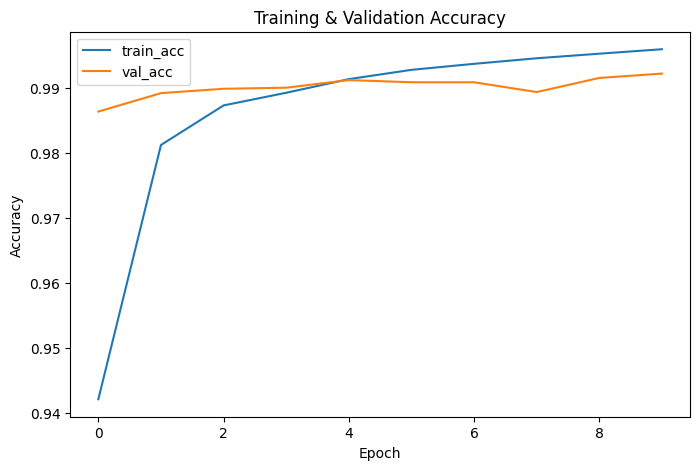

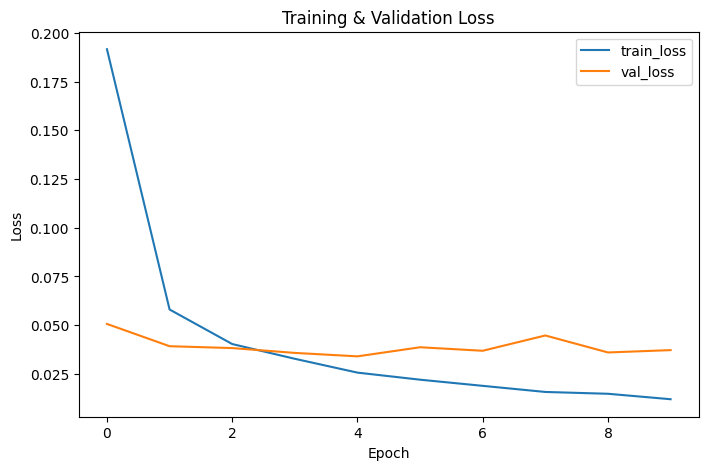

In [11]:
# Plot accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')
plt.show()


# Plot loss
plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')
plt.show()

10. Generate predictions

In [17]:
# Make predictions (for CNN model)
y_pred_probs = model.predict(X_test_cnn)

# Convert probabilities to class labels
pred_classes = np.argmax(y_pred_probs, axis=1)


313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


11. Predictions & visualization of sample digits

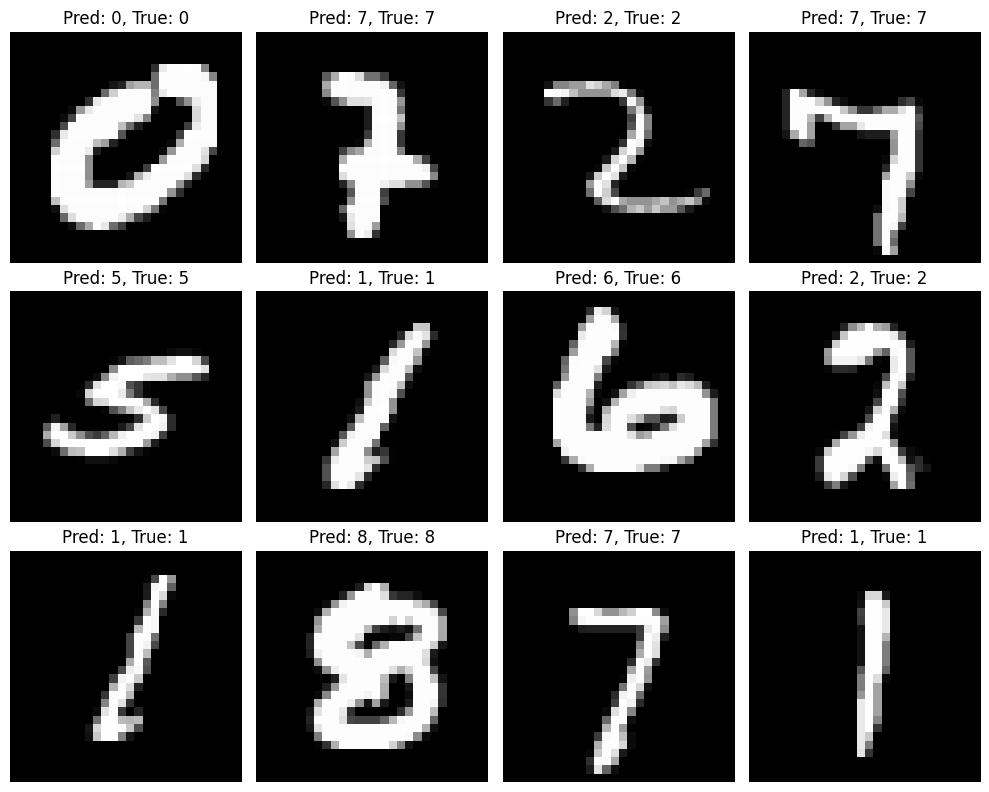

In [18]:
import random

n_samples = 12
idx = random.sample(range(len(y_test)), n_samples)

fig, axes = plt.subplots(3, 4, figsize=(10, 8))

for ax, i in zip(axes.flatten(), idx):
    img = X_test_cnn[i].reshape(28, 28)  # reshape for display
    ax.imshow(img, cmap="gray")
    ax.set_title(f"Pred: {pred_classes[i]}, True: {y_test[i]}")
    ax.axis("off")

plt.tight_layout()
plt.show()


12. Save & load the model

In [21]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])


13. Upgrade Gradio

In [26]:
pip install --upgrade gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.6/324.6 kB 22.8 MB/s eta 0:00:00
  Attempting uninstall: gradio-client
    Found existing installation: gradio_client 1.11.1
    Uninstalling gradio_client-1.11.1:
      Successfully uninstalled gradio_client-1.11.1
  Attempting uninstall: gradio
    Found existing installation: gradio 5.42.0
    Uninstalling gradio-5.42.0:
      Successfully uninstalled gradio-5.42.0


14. Gradio App

In [ ]:
import gradio as gr
import numpy as np
import cv2
import tensorflow as tf

# Load trained model
model = tf.keras.models.load_model("best_mnist_model.h5")

def predict_digit(img):
    print("🔥 DEBUG - Raw input type:", type(img))

    if img is None:
        return {str(i): 0.0 for i in range(10)}

    # If input is dict (Sketchpad case), extract composite image
    if isinstance(img, dict) and "composite" in img:
        img = img["composite"]

    # Now img should be a numpy array
    print("🔥 DEBUG - Processed input type:", type(img), "Shape:", getattr(img, "shape", None))

    # Convert to grayscale
    if img.ndim == 3 and img.shape[-1] == 4:  # RGBA
        img = cv2.cvtColor(img, cv2.COLOR_RGBA2GRAY)
    elif img.ndim == 3 and img.shape[-1] == 3:  # RGB
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    elif img.ndim == 2:  # Already grayscale
        pass
    else:
        print("⚠️ Unexpected image shape:", img.shape)
        return {str(i): 0.0 for i in range(10)}

    # Resize & normalize
    img = cv2.resize(img, (28, 28))
    img = img / 255.0
    img = img.reshape(1, 28, 28, 1)

    preds = model.predict(img)
    return {str(i): float(preds[0][i]) for i in range(10)}

# Gradio App
with gr.Blocks() as demo:
    gr.Markdown("## 🖌️ Handwritten Digit Recognition (MNIST)")

    with gr.Tab("✍️ Draw Digit"):
        draw = gr.Sketchpad(canvas_size=(280, 280), image_mode="RGBA")
        label_output = gr.Label(num_top_classes=3)
        btn1 = gr.Button("Predict")
        btn1.click(predict_digit, inputs=draw, outputs=label_output)

    with gr.Tab("📂 Upload Image"):
        upload = gr.Image(type="numpy", image_mode="L")
        label_output2 = gr.Label(num_top_classes=3)
        btn2 = gr.Button("Predict")
        btn2.click(predict_digit, inputs=upload, outputs=label_output2)

demo.launch(debug=True)


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://8132668882a7947b87.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


🔥 DEBUG - Raw input type: <class 'dict'>
🔥 DEBUG - Processed input type: <class 'numpy.ndarray'> Shape: (280, 280, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
🔥 DEBUG - Raw input type: <class 'dict'>
🔥 DEBUG - Processed input type: <class 'numpy.ndarray'> Shape: (280, 280, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
🔥 DEBUG - Raw input type: <class 'dict'>
🔥 DEBUG - Processed input type: <class 'numpy.ndarray'> Shape: (280, 280, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
🔥 DEBUG - Raw input type: <class 'dict'>
🔥 DEBUG - Processed input type: <class 'numpy.ndarray'> Shape: (280, 280, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
🔥 DEBUG - Raw input type: <class 'dict'>
🔥 DEBUG - Processed input type: <class 'numpy.ndarray'> Shape: (280, 280, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
🔥 DEBUG - Raw input type: <class 'dict'>
🔥 DEBUG - Processed input type: <class 'numpy.ndarray'> Shape: (280, 280, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
🔥 DEBUG - Raw input type: <class 'dict'>
🔥 DEBUG - Processed in